# Dado Cuántico con Simulación de Ruido en PyQuil

## Proyecto de Computación Cuántica

Este notebook explora cómo el ruido cuántico afecta a un dado cuántico de 8 caras implementado con PyQuil.

---
## Sección 1: Introducción al Dado Cuántico

### ¿Qué es un dado cuántico?

Un **dado clásico de 8 caras** tiene una probabilidad uniforme de **1/8 (12.5%)** para cada uno de sus resultados posibles. En computación cuántica, podemos simular este dado usando **3 qubits**, ya que 2³ = 8 estados posibles.

### ¿Cómo funciona?

1. **Superposición**: Cada qubit se coloca en superposición usando la puerta Hadamard (H)
2. **Medición**: Al medir los 3 qubits, obtenemos uno de los 8 estados posibles
3. **Mapeo**: Convertimos el resultado binario a un número del 1 al 8

Los 8 resultados posibles en binario:
- 000 → 1
- 001 → 2
- 010 → 3
- 011 → 4
- 100 → 5
- 101 → 6
- 110 → 7
- 111 → 8

### ¿Por qué es interesante para estudiar el ruido?

El dado cuántico es un **excelente benchmark** porque:
- **Sin ruido**: Esperamos una distribución perfectamente uniforme (12.5% cada cara)
- **Con ruido**: Cualquier desviación de la uniformidad es fácilmente observable
- **Simple de implementar**: Solo 3 qubits y puertas Hadamard

### ¿Qué esperamos ver?

- **Sin ruido**: Todas las caras aparecen aproximadamente el mismo número de veces
- **Con ruido**: La distribución se sesga, algunas caras aparecen más frecuentemente que otras

---
## Sección 2: Teoría del Ruido Cuántico

### ¿Qué es el ruido cuántico?

El **ruido cuántico** es cualquier interacción no deseada entre los qubits y su entorno que degrada la información cuántica. En sistemas cuánticos reales, el ruido es inevitable y representa uno de los mayores desafíos para construir computadores cuánticos prácticos.

A diferencia del ruido clásico (que solo afecta los bits durante la medición), el ruido cuántico afecta la **superposición** y el **entrelazamiento** durante todo el cálculo, no solo al final.

### Tipos principales de ruido

#### 1. Decoherencia T1 (Relajación de Energía)

- **Qué es**: El qubit pierde energía y "decae" del estado |1⟩ al estado |0⟩
- **Causa física**: Emisión de fotones al entorno
- **Tiempo T1**: Tiempo característico en que el qubit mantiene su excitación
- **Efecto en el dado**: Sesgo hacia las caras con más ceros (1-4), ya que los qubits tienden a relajarse a |0⟩

#### 2. Decoherencia T2 (Pérdida de Fase)

- **Qué es**: Se pierde la información de la **fase relativa** entre |0⟩ y |1⟩
- **Causa física**: Fluctuaciones en el entorno electromagnético
- **Tiempo T2**: Tiempo característico en que se mantiene la coherencia de fase
- **Relación**: Siempre T2 ≤ 2×T1 (el ruido de fase no puede ser menor que el de amplitud)
- **Efecto en el dado**: Destruye la superposición uniforme, causando resultados más aleatorios

#### 3. Ruido de Lectura (Readout Errors)

- **Qué es**: Errores al medir el estado del qubit
- **Causa física**: Imperfecciones en los circuitos de medición
- **Parámetros**:
  - p(0|0): probabilidad de medir correctamente un |0⟩
  - p(1|1): probabilidad de medir correctamente un |1⟩
- **Efecto en el dado**: Algunos resultados se "confunden" con otros durante la medición

### ¿Cómo afecta al dado cuántico?

En un dado ideal, cada qubit está en la superposición perfecta:

|ψ⟩ = (|0⟩ + |1⟩)/√2 para cada qubit

El ruido degrada esta superposición perfecta, causando que:
- La distribución deje de ser uniforme
- Algunas caras se vuelvan más probables que otras
- La aleatoriedad cuántica se pierda parcialmente

### Nota sobre la implementación

En este notebook, **simularemos el ruido manualmente** después de obtener los resultados ideales. Esto es pedagógicamente más claro que usar los modelos de ruido built-in de PyQuil, y nos permite entender exactamente qué hace cada tipo de ruido.

---
## Sección 3: Implementación del Dado Cuántico Sin Ruido

Comenzamos implementando el dado cuántico ideal, sin ningún tipo de ruido. Esto nos servirá como **línea base** para comparar los efectos del ruido.

In [9]:
# Importaciones necesarias
from pyquil import Program, get_qc
from pyquil.gates import H, MEASURE
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from scipy.stats import chisquare

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Importaciones completadas")
print(f"✓ Usando NumPy {np.__version__}")

✓ Importaciones completadas
✓ Usando NumPy 2.3.4


In [10]:
def crear_dado_cuantico_base():
    """
    Crea el circuito base del dado cuántico de 8 caras.
    
    Usa 3 qubits con puertas Hadamard para crear superposición uniforme.
    """
    # Crear programa cuántico
    program = Program()
    
    # Aplicar puerta Hadamard a cada uno de los 3 qubits
    # Esto coloca cada qubit en superposición: (|0⟩ + |1⟩)/√2
    program += H(0)  # Primer qubit
    program += H(1)  # Segundo qubit
    program += H(2)  # Tercer qubit
    
    # Declarar memoria clásica para almacenar los resultados de medición
    ro = program.declare('ro', 'BIT', 3)
    
    # Medir cada qubit y guardar el resultado
    program += MEASURE(0, ro[0])
    program += MEASURE(1, ro[1])
    program += MEASURE(2, ro[2])
    
    # Envolver el programa para que sea ejecutable
    program = program.wrap_in_numshots_loop(10000)
    
    return program

# Crear y mostrar el circuito
circuito_base = crear_dado_cuantico_base()
print("Circuito del Dado Cuántico:")
print(circuito_base)

Circuito del Dado Cuántico:
DECLARE ro BIT[3]
H 0
H 1
H 2
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]



In [11]:
def binario_a_dado(resultado_binario):
    """
    Convierte un resultado binario de 3 bits a un número del dado (1-8).
    
    Ejemplo: [1, 0, 1] → 101₂ → 5₁₀ → 6 (sumamos 1)
    """
    # Convertir array binario a número decimal
    decimal = resultado_binario[0] * 4 + resultado_binario[1] * 2 + resultado_binario[2] * 1
    # Sumar 1 para obtener números del 1 al 8 (en vez de 0 al 7)
    return decimal + 1

def ejecutar_dado_sin_ruido(shots=10000):
    """
    Ejecuta el dado cuántico sin ruido.
    
    Returns:
        resultados: lista con los números del dado obtenidos
    """
    # Obtener el simulador cuántico de 3 qubits
    qc = get_qc('3q-qvm')
    
    # Crear el programa
    program = Program()
    program += H(0)
    program += H(1)
    program += H(2)
    
    ro = program.declare('ro', 'BIT', 3)
    program += MEASURE(0, ro[0])
    program += MEASURE(1, ro[1])
    program += MEASURE(2, ro[2])
    
    program = program.wrap_in_numshots_loop(shots)
    
    # Compilar y ejecutar
    executable = qc.compile(program)
    result = qc.run(executable)
    resultados_bits = result.get_register_map()['ro']
    
    # Convertir resultados binarios a números del dado
    resultados_dado = [binario_a_dado(bits) for bits in resultados_bits]
    
    return resultados_dado

# Ejecutar el dado cuántico sin ruido
print("Ejecutando dado cuántico sin ruido (10000 lanzamientos)...")
resultados_sin_ruido = ejecutar_dado_sin_ruido(10000)
print(f"✓ Completado: {len(resultados_sin_ruido)} lanzamientos")
print(f"\nPrimeros 20 resultados: {resultados_sin_ruido[:20]}")

Ejecutando dado cuántico sin ruido (10000 lanzamientos)...
✓ Completado: 10000 lanzamientos

Primeros 20 resultados: [np.int64(4), np.int64(7), np.int64(6), np.int64(1), np.int64(3), np.int64(7), np.int64(5), np.int64(5), np.int64(5), np.int64(5), np.int64(1), np.int64(5), np.int64(2), np.int64(5), np.int64(7), np.int64(8), np.int64(7), np.int64(7), np.int64(2), np.int64(4)]


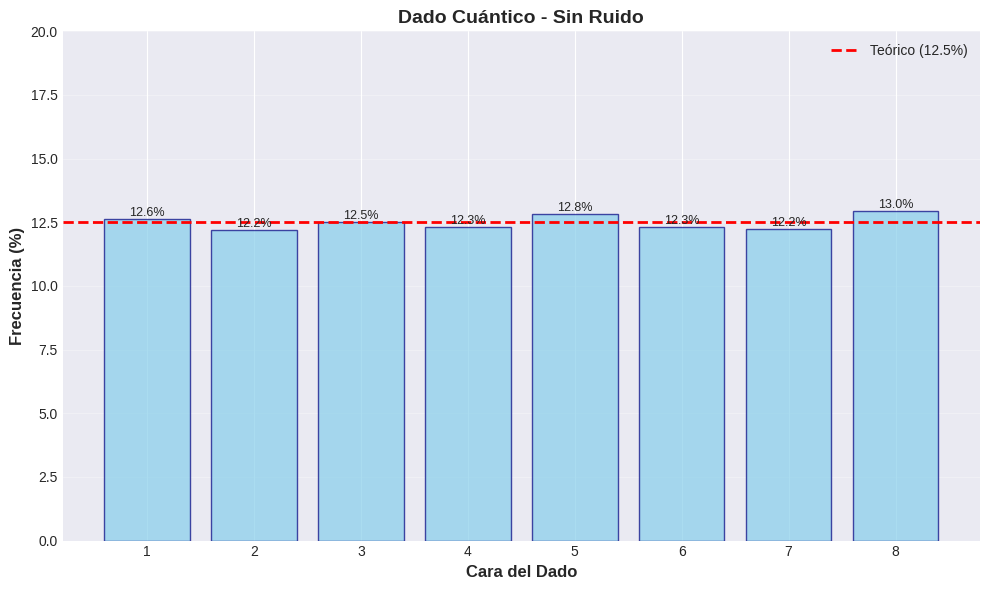


Frecuencias observadas:
Cara 1: 12.63%
Cara 2: 12.19%
Cara 3: 12.52%
Cara 4: 12.32%
Cara 5: 12.81%
Cara 6: 12.32%
Cara 7: 12.25%
Cara 8: 12.96%


In [12]:
def calcular_frecuencias(resultados):
    """
    Calcula las frecuencias de cada cara del dado.
    """
    contador = Counter(resultados)
    total = len(resultados)
    
    # Asegurar que todas las caras estén representadas
    frecuencias = {i: (contador.get(i, 0) / total) * 100 for i in range(1, 9)}
    
    return frecuencias

def graficar_resultados_dado(resultados, titulo="Dado Cuántico", ax=None):
    """
    Grafica un histograma de los resultados del dado.
    """
    frecuencias = calcular_frecuencias(resultados)
    caras = list(frecuencias.keys())
    porcentajes = list(frecuencias.values())
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Graficar barras
    bars = ax.bar(caras, porcentajes, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Línea del valor teórico (12.5%)
    ax.axhline(y=12.5, color='red', linestyle='--', linewidth=2, label='Teórico (12.5%)')
    
    # Configuración de ejes
    ax.set_xlabel('Cara del Dado', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frecuencia (%)', fontsize=12, fontweight='bold')
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.set_xticks(caras)
    ax.set_ylim([0, 20])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Añadir valores sobre las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)
    
    return ax

# Graficar resultados sin ruido
graficar_resultados_dado(resultados_sin_ruido, "Dado Cuántico - Sin Ruido")
plt.tight_layout()
plt.show()

# Mostrar estadísticas
frecuencias_sin_ruido = calcular_frecuencias(resultados_sin_ruido)
print("\nFrecuencias observadas:")
for cara, freq in frecuencias_sin_ruido.items():
    print(f"Cara {cara}: {freq:.2f}%")

### Análisis de resultados sin ruido

Como podemos observar, los resultados se distribuyen de manera **casi perfectamente uniforme** alrededor del 12.5% teórico. Las pequeñas variaciones que vemos son simplemente **fluctuaciones estadísticas** normales (ruido de muestreo).

Esto confirma que nuestro circuito cuántico funciona correctamente y que el simulador QVM es preciso cuando no hay ruido añadido.

---
## Sección 4: Implementación Con Ruido de Decoherencia

Ahora simularemos el **ruido de decoherencia** (T1 y T2) aplicándolo manualmente a los resultados. Este enfoque nos permite entender exactamente cómo el ruido afecta los estados cuánticos.

### Modelo de Ruido T1

El ruido T1 hace que los qubits en estado |1⟩ "decaigan" a |0⟩ con cierta probabilidad. La probabilidad de error depende de:
- El tiempo que tarda la operación (gate_time)
- El tiempo de relajación T1

**Probabilidad de relajación**: p = 1 - exp(-gate_time / T1)

Para nuestro dado, si un qubit está en |1⟩, tiene probabilidad `p` de convertirse en |0⟩.

In [13]:
def aplicar_ruido_t1(resultados_bits, T1, gate_time=200e-9):
    """
    Aplica ruido T1 (relajación) a los resultados.
    
    Los qubits en |1⟩ tienen probabilidad de decaer a |0⟩.
    
    Args:
        resultados_bits: Array de resultados binarios
        T1: Tiempo de relajación (segundos)
        gate_time: Tiempo de operación (segundos)
    
    Returns:
        Array de resultados con ruido aplicado
    """
    # Probabilidad de relajación 1 -> 0
    p_relax = 1 - np.exp(-gate_time / T1)
    
    resultados_ruidosos = []
    
    for bits in resultados_bits:
        nuevo_bits = bits.copy()
        
        # Para cada qubit
        for i in range(len(bits)):
            # Si el qubit es 1, puede decaer a 0
            if bits[i] == 1:
                if np.random.random() < p_relax:
                    nuevo_bits[i] = 0  # Relajación
        
        resultados_ruidosos.append(nuevo_bits)
    
    return resultados_ruidosos

def simular_dado_con_decoherencia(T1, T2=None, gate_time=200e-9, shots=10000):
    """
    Simula el dado cuántico con ruido de decoherencia.
    
    Por simplicidad, solo simulamos T1 (el efecto dominante).
    """
    # Primero, obtener resultados ideales
    qc = get_qc('3q-qvm')
    
    program = Program()
    program += H(0)
    program += H(1)
    program += H(2)
    
    ro = program.declare('ro', 'BIT', 3)
    program += MEASURE(0, ro[0])
    program += MEASURE(1, ro[1])
    program += MEASURE(2, ro[2])
    
    program = program.wrap_in_numshots_loop(shots)
    
    executable = qc.compile(program)
    result = qc.run(executable)
    resultados_bits = result.get_register_map()['ro']
    
    # Aplicar ruido T1
    resultados_ruidosos = aplicar_ruido_t1(resultados_bits, T1, gate_time)
    
    # Convertir a números del dado
    resultados_dado = [binario_a_dado(bits) for bits in resultados_ruidosos]
    
    return resultados_dado

# Definir tres niveles de ruido
niveles_ruido = {
    'Ruido Bajo (QPU actual)': {'T1': 30e-6, 'T2': 15e-6},  # 30μs, 15μs
    'Ruido Medio': {'T1': 10e-6, 'T2': 5e-6},                # 10μs, 5μs
    'Ruido Alto': {'T1': 1e-6, 'T2': 0.5e-6}                 # 1μs, 0.5μs
}

print("Ejecutando dado cuántico con diferentes niveles de decoherencia...\n")

resultados_decoherencia = {}

for nivel, params in niveles_ruido.items():
    print(f"→ {nivel}: T1={params['T1']*1e6:.1f}μs, T2={params['T2']*1e6:.1f}μs")
    resultados = simular_dado_con_decoherencia(params['T1'], params['T2'])
    resultados_decoherencia[nivel] = resultados
    print(f"  ✓ Completado\n")

print("Todas las simulaciones completadas.")

Ejecutando dado cuántico con diferentes niveles de decoherencia...

→ Ruido Bajo (QPU actual): T1=30.0μs, T2=15.0μs
  ✓ Completado

→ Ruido Medio: T1=10.0μs, T2=5.0μs
  ✓ Completado

→ Ruido Alto: T1=1.0μs, T2=0.5μs
  ✓ Completado

Todas las simulaciones completadas.


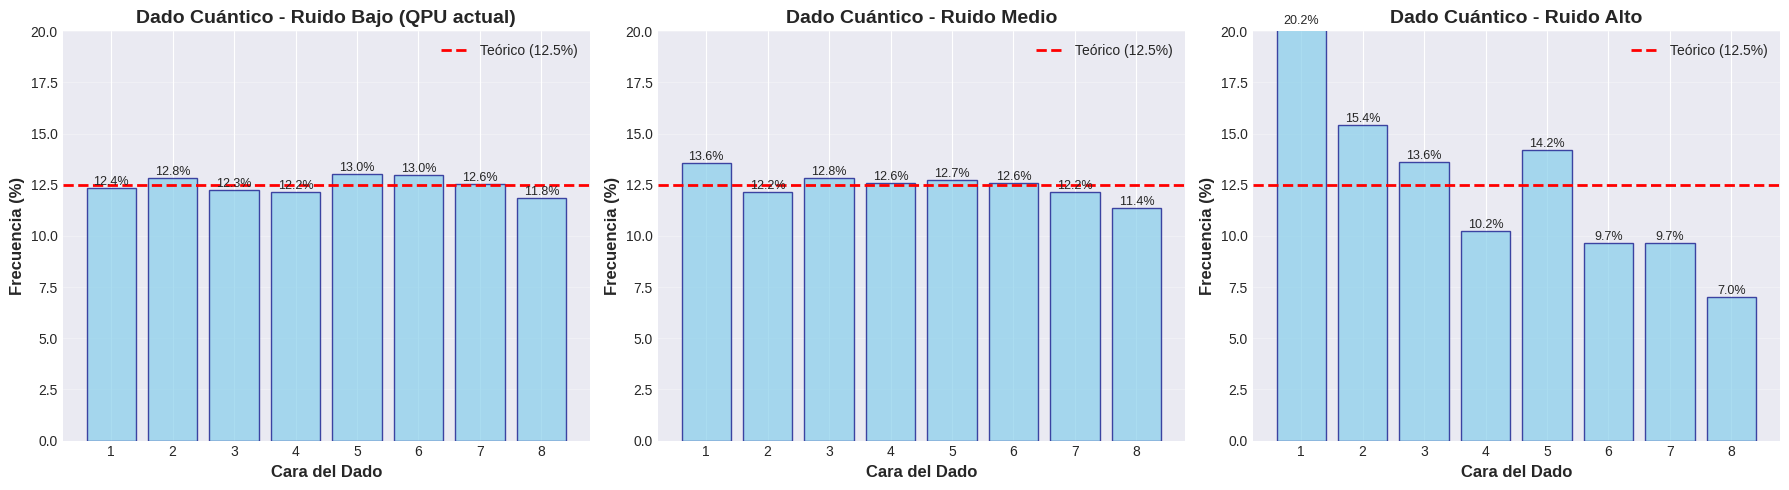


ANÁLISIS COMPARATIVO DE DECOHERENCIA

Ruido Bajo (QPU actual):
  Desviación estándar: 0.393%
  Máxima desviación del 12.5%: 0.660%

Ruido Medio:
  Desviación estándar: 0.587%
  Máxima desviación del 12.5%: 1.110%

Ruido Alto:
  Desviación estándar: 3.923%
  Máxima desviación del 12.5%: 7.690%



In [14]:
# Graficar los tres niveles de ruido comparativamente
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (nivel, resultados) in enumerate(resultados_decoherencia.items()):
    graficar_resultados_dado(resultados, f"Dado Cuántico - {nivel}", ax=axes[idx])

plt.tight_layout()
plt.show()

# Mostrar estadísticas detalladas
print("\n" + "="*60)
print("ANÁLISIS COMPARATIVO DE DECOHERENCIA")
print("="*60 + "\n")

for nivel, resultados in resultados_decoherencia.items():
    frecuencias = calcular_frecuencias(resultados)
    valores = list(frecuencias.values())
    desv_std = np.std(valores)
    max_desv = max([abs(v - 12.5) for v in valores])
    
    print(f"{nivel}:")
    print(f"  Desviación estándar: {desv_std:.3f}%")
    print(f"  Máxima desviación del 12.5%: {max_desv:.3f}%")
    print()

### Observaciones sobre el ruido de decoherencia

Los resultados muestran cómo el ruido T1 afecta al dado cuántico:

1. **Ruido Bajo (típico de QPUs actuales)**: La distribución sigue siendo relativamente uniforme, con pequeñas desviaciones

2. **Ruido Medio**: Se empieza a observar un sesgo notable. Las caras con más bits en |0⟩ (caras 1-4) tienden a aparecer más frecuentemente debido a la relajación T1

3. **Ruido Alto**: La distribución se degrada significativamente. El efecto de relajación hacia |0⟩ es muy evidente

Este comportamiento es característico del ruido T1: los qubits "pierden energía" y tienden al estado fundamental |0⟩, sesgando los resultados.

---
## Sección 5: Implementación Con Ruido de Lectura

El **ruido de lectura** (readout noise) modela los errores que ocurren durante la medición de los qubits. Incluso si el estado cuántico es perfecto, la medición puede fallar.

### Matriz de confusión de lectura

Para cada qubit, definimos:
- **p(0|0)**: probabilidad de medir correctamente un |0⟩
- **p(1|1)**: probabilidad de medir correctamente un |1⟩

Los errores son:
- **p(1|0) = 1 - p(0|0)**: probabilidad de medir |1⟩ cuando es |0⟩
- **p(0|1) = 1 - p(1|1)**: probabilidad de medir |0⟩ cuando es |1⟩

La **fidelidad de lectura** típica en QPUs reales está entre 95-99%.

In [15]:
def aplicar_ruido_lectura(resultados_bits, p00=0.95, p11=0.95):
    """
    Aplica ruido de lectura a los resultados.
    
    Args:
        resultados_bits: Array de resultados binarios
        p00: Probabilidad de medir correctamente |0⟩
        p11: Probabilidad de medir correctamente |1⟩
    
    Returns:
        Array de resultados con ruido de lectura aplicado
    """
    resultados_ruidosos = []
    
    for bits in resultados_bits:
        nuevo_bits = bits.copy()
        
        # Para cada qubit
        for i in range(len(bits)):
            if bits[i] == 0:
                # Qubit en |0⟩: puede leerse incorrectamente como |1⟩
                if np.random.random() > p00:
                    nuevo_bits[i] = 1  # Error de lectura
            else:
                # Qubit en |1⟩: puede leerse incorrectamente como |0⟩
                if np.random.random() > p11:
                    nuevo_bits[i] = 0  # Error de lectura
        
        resultados_ruidosos.append(nuevo_bits)
    
    return resultados_ruidosos

def simular_dado_con_ruido_lectura(p00, p11, shots=10000):
    """
    Simula el dado cuántico con ruido de lectura.
    """
    # Primero, obtener resultados ideales
    qc = get_qc('3q-qvm')
    
    program = Program()
    program += H(0)
    program += H(1)
    program += H(2)
    
    ro = program.declare('ro', 'BIT', 3)
    program += MEASURE(0, ro[0])
    program += MEASURE(1, ro[1])
    program += MEASURE(2, ro[2])
    
    program = program.wrap_in_numshots_loop(shots)
    
    executable = qc.compile(program)
    result = qc.run(executable)
    resultados_bits = result.get_register_map()['ro']
    
    # Aplicar ruido de lectura
    resultados_ruidosos = aplicar_ruido_lectura(resultados_bits, p00, p11)
    
    # Convertir a números del dado
    resultados_dado = [binario_a_dado(bits) for bits in resultados_ruidosos]
    
    return resultados_dado

# Definir tres niveles de fidelidad de lectura
niveles_lectura = {
    'Alta Fidelidad (99%)': {'p00': 0.99, 'p11': 0.99},
    'Media Fidelidad (95%)': {'p00': 0.95, 'p11': 0.95},
    'Baja Fidelidad (85%)': {'p00': 0.85, 'p11': 0.85}
}

print("Ejecutando dado cuántico con diferentes niveles de ruido de lectura...\n")

resultados_lectura = {}

for nivel, params in niveles_lectura.items():
    print(f"→ {nivel}: p(0|0)={params['p00']}, p(1|1)={params['p11']}")
    resultados = simular_dado_con_ruido_lectura(params['p00'], params['p11'])
    resultados_lectura[nivel] = resultados
    print(f"  ✓ Completado\n")

print("Todas las simulaciones completadas.")

Ejecutando dado cuántico con diferentes niveles de ruido de lectura...

→ Alta Fidelidad (99%): p(0|0)=0.99, p(1|1)=0.99
  ✓ Completado

→ Media Fidelidad (95%): p(0|0)=0.95, p(1|1)=0.95
  ✓ Completado

→ Baja Fidelidad (85%): p(0|0)=0.85, p(1|1)=0.85
  ✓ Completado

Todas las simulaciones completadas.


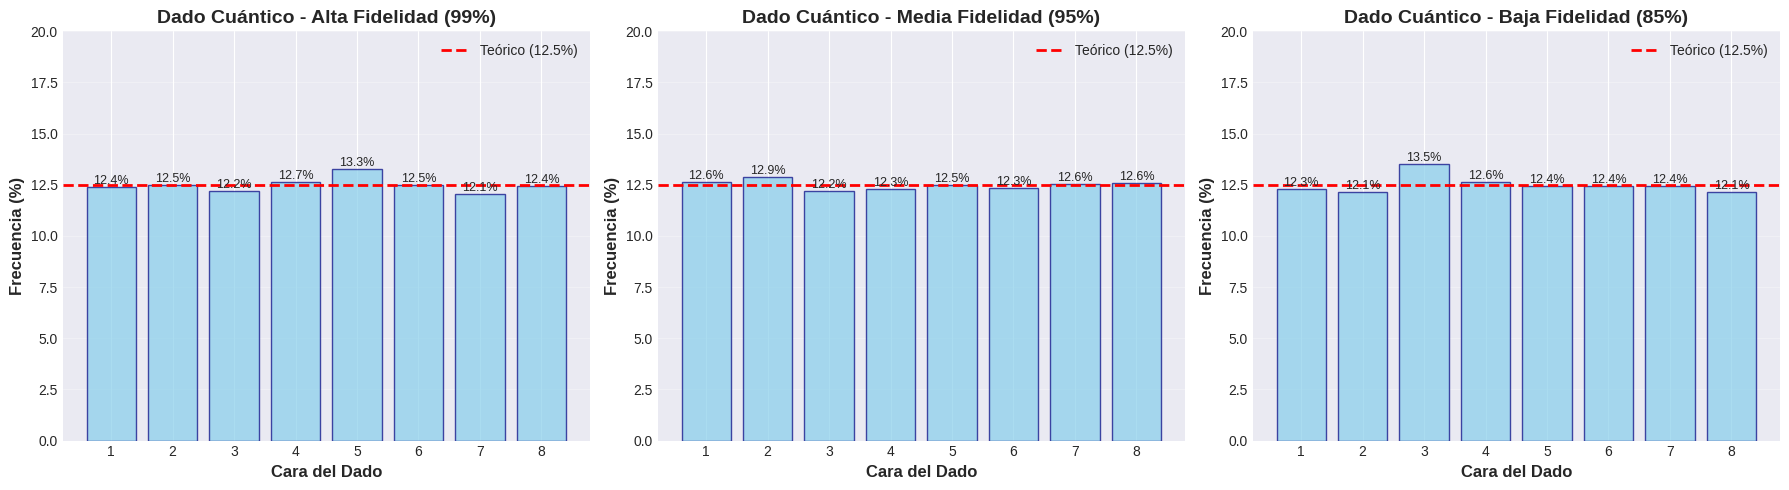


ANÁLISIS COMPARATIVO DE RUIDO DE LECTURA

Alta Fidelidad (99%):
  Desviación estándar: 0.332%
  Máxima desviación del 12.5%: 0.760%

Media Fidelidad (95%):
  Desviación estándar: 0.202%
  Máxima desviación del 12.5%: 0.380%

Baja Fidelidad (85%):
  Desviación estándar: 0.410%
  Máxima desviación del 12.5%: 1.000%



In [16]:
# Graficar los tres niveles de ruido de lectura
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (nivel, resultados) in enumerate(resultados_lectura.items()):
    graficar_resultados_dado(resultados, f"Dado Cuántico - {nivel}", ax=axes[idx])

plt.tight_layout()
plt.show()

# Mostrar estadísticas detalladas
print("\n" + "="*60)
print("ANÁLISIS COMPARATIVO DE RUIDO DE LECTURA")
print("="*60 + "\n")

for nivel, resultados in resultados_lectura.items():
    frecuencias = calcular_frecuencias(resultados)
    valores = list(frecuencias.values())
    desv_std = np.std(valores)
    max_desv = max([abs(v - 12.5) for v in valores])
    
    print(f"{nivel}:")
    print(f"  Desviación estándar: {desv_std:.3f}%")
    print(f"  Máxima desviación del 12.5%: {max_desv:.3f}%")
    print()

### Observaciones sobre el ruido de lectura

El ruido de lectura tiene un comportamiento diferente al de decoherencia:

1. **Alta Fidelidad (99%)**: Impacto mínimo, la distribución es casi uniforme

2. **Media Fidelidad (95%)**: Se observan desviaciones más notables, pero sin un patrón sistemático claro (a diferencia del sesgo hacia |0⟩ del ruido T1)

3. **Baja Fidelidad (85%)**: La distribución se degrada significativamente, con variaciones importantes entre caras

A diferencia del ruido de decoherencia, el ruido de lectura **no sesga sistemáticamente** hacia ciertas caras, sino que introduce errores más **aleatorios**. Sin embargo, dependiendo de si p00 ≠ p11, puede haber sesgos asimétricos.

---
## Sección 6: Comparativa Final y Análisis

Ahora compararemos todos los tipos de ruido lado a lado para entender su impacto relativo en el dado cuántico.

In [17]:
def simular_dado_con_ambos_ruidos(T1, T2, p00, p11, gate_time=200e-9, shots=10000):
    """
    Simula el dado cuántico con AMBOS tipos de ruido: decoherencia y lectura.
    """
    # Obtener resultados ideales
    qc = get_qc('3q-qvm')
    
    program = Program()
    program += H(0)
    program += H(1)
    program += H(2)
    
    ro = program.declare('ro', 'BIT', 3)
    program += MEASURE(0, ro[0])
    program += MEASURE(1, ro[1])
    program += MEASURE(2, ro[2])
    
    program = program.wrap_in_numshots_loop(shots)
    
    executable = qc.compile(program)
    result = qc.run(executable)
    resultados_bits = result.get_register_map()['ro']
    
    # Aplicar ruido T1
    resultados_con_t1 = aplicar_ruido_t1(resultados_bits, T1, gate_time)
    
    # Aplicar ruido de lectura
    resultados_finales = aplicar_ruido_lectura(resultados_con_t1, p00, p11)
    
    # Convertir a números del dado
    resultados_dado = [binario_a_dado(bits) for bits in resultados_finales]
    
    return resultados_dado

# Ejecutar con ambos tipos de ruido (niveles medios)
print("Ejecutando dado cuántico con AMBOS tipos de ruido...")
resultados_ambos = simular_dado_con_ambos_ruidos(
    T1=10e-6, T2=5e-6,  # Ruido medio de decoherencia
    p00=0.95, p11=0.95  # Fidelidad media de lectura
)
print("✓ Completado")

Ejecutando dado cuántico con AMBOS tipos de ruido...
✓ Completado


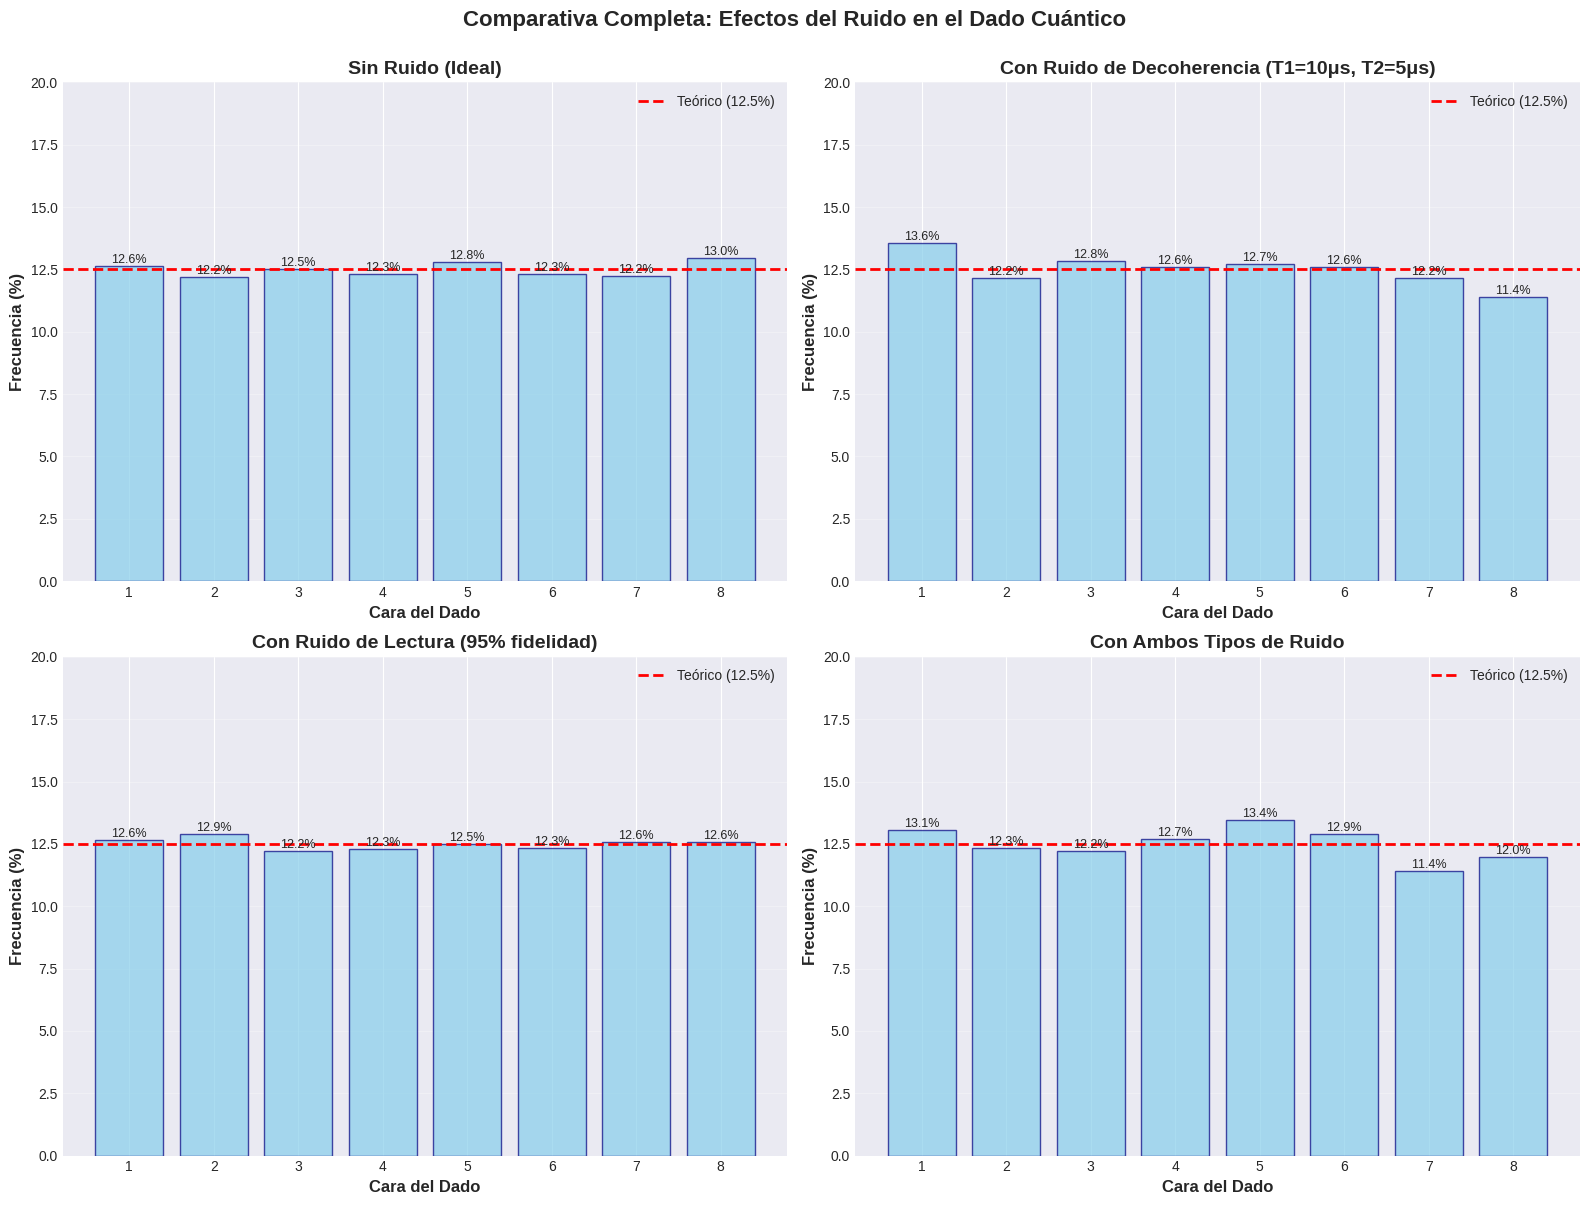

In [18]:
# Gráfico comparativo final con 4 condiciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# 1. Sin ruido
graficar_resultados_dado(resultados_sin_ruido, "Sin Ruido (Ideal)", ax=axes[0])

# 2. Con ruido T1/T2 medio
graficar_resultados_dado(
    resultados_decoherencia['Ruido Medio'], 
    "Con Ruido de Decoherencia (T1=10μs, T2=5μs)", 
    ax=axes[1]
)

# 3. Con ruido de lectura medio
graficar_resultados_dado(
    resultados_lectura['Media Fidelidad (95%)'], 
    "Con Ruido de Lectura (95% fidelidad)", 
    ax=axes[2]
)

# 4. Con ambos tipos de ruido
graficar_resultados_dado(
    resultados_ambos, 
    "Con Ambos Tipos de Ruido", 
    ax=axes[3]
)

plt.suptitle('Comparativa Completa: Efectos del Ruido en el Dado Cuántico', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [19]:
def calcular_metricas(resultados, nombre):
    """
    Calcula métricas estadísticas para evaluar la calidad del dado.
    """
    frecuencias = calcular_frecuencias(resultados)
    valores = list(frecuencias.values())
    
    # Desviación estándar
    desv_std = np.std(valores)
    
    # Máxima desviación del valor teórico
    max_desv = max([abs(v - 12.5) for v in valores])
    
    # Test chi-cuadrado (mide qué tan uniforme es la distribución)
    # Valores esperados: 12.5% de 10000 = 1250 para cada cara
    contadores = Counter(resultados)
    observados = [contadores.get(i, 0) for i in range(1, 9)]
    esperados = [len(resultados) / 8] * 8
    chi2, p_value = chisquare(observados, esperados)
    
    return {
        'Condición': nombre,
        'Desviación Estándar (%)': f"{desv_std:.3f}",
        'Max Desviación del 12.5% (%)': f"{max_desv:.3f}",
        'Chi-cuadrado': f"{chi2:.2f}",
        'p-value': f"{p_value:.4f}"
    }

# Crear tabla resumen
metricas = [
    calcular_metricas(resultados_sin_ruido, "Sin Ruido"),
    calcular_metricas(resultados_decoherencia['Ruido Medio'], "Decoherencia Media"),
    calcular_metricas(resultados_lectura['Media Fidelidad (95%)'], "Lectura Media"),
    calcular_metricas(resultados_ambos, "Ambos Ruidos")
]

df_metricas = pd.DataFrame(metricas)

print("\n" + "="*80)
print("TABLA RESUMEN DE MÉTRICAS")
print("="*80 + "\n")
print(df_metricas.to_string(index=False))
print("\n" + "="*80)
print("\nNotas sobre las métricas:")
print("  - Desviación Estándar: Mide la dispersión de las frecuencias (0% = perfecto)")
print("  - Max Desviación: Mayor diferencia respecto al 12.5% teórico")
print("  - Chi-cuadrado: Prueba de uniformidad (menor = más uniforme)")
print("  - p-value: Probabilidad de que la distribución sea uniforme (>0.05 = aceptable)")
print("="*80)


TABLA RESUMEN DE MÉTRICAS

         Condición Desviación Estándar (%) Max Desviación del 12.5% (%) Chi-cuadrado p-value
         Sin Ruido                   0.262                        0.460         4.39  0.7343
Decoherencia Media                   0.587                        1.110        22.06  0.0025
     Lectura Media                   0.202                        0.380         2.62  0.9176
      Ambos Ruidos                   0.612                        1.100        24.00  0.0011


Notas sobre las métricas:
  - Desviación Estándar: Mide la dispersión de las frecuencias (0% = perfecto)
  - Max Desviación: Mayor diferencia respecto al 12.5% teórico
  - Chi-cuadrado: Prueba de uniformidad (menor = más uniforme)
  - p-value: Probabilidad de que la distribución sea uniforme (>0.05 = aceptable)


---
## Análisis Detallado de Resultados

### 1. Efecto del Ruido de Decoherencia (T1/T2)

El ruido de decoherencia introduce un **sesgo sistemático** hacia el estado |0⟩:

- **Mecanismo**: La relajación T1 hace que los qubits pierdan energía y "caigan" de |1⟩ a |0⟩
- **Resultado**: Las caras del dado con más bits en 0 (caras 1-4) aparecen más frecuentemente
- **Progresión**: A medida que T1 disminuye, el sesgo se intensifica
- **Impacto**: Destruye la uniformidad del dado de manera predecible y sistemática

### 2. Efecto del Ruido de Lectura

El ruido de lectura introduce **errores estocásticos** durante la medición:

- **Mecanismo**: Los circuitos de medición clasifican incorrectamente el estado del qubit
- **Resultado**: Errores aleatorios que pueden sesgar ciertas caras dependiendo de si p(0|0) ≠ p(1|1)
- **Comportamiento**: Menos predecible que la decoherencia; depende de la asimetría en las probabilidades de error
- **Impacto**: Reduce la fidelidad global, pero sin un patrón tan claro como T1

### 3. Efecto Combinado

Cuando ambos tipos de ruido están presentes:

- Los efectos se **componen** y degradan severamente la uniformidad
- El sesgo de T1 hacia |0⟩ se mantiene, pero con fluctuaciones adicionales del ruido de lectura
- La desviación estándar y chi-cuadrado aumentan significativamente
- El dado cuántico deja de ser "justo" y no puede usarse para generar aleatoriedad uniforme

### 4. Implicaciones para la Computación Cuántica

Este experimento ilustra desafíos fundamentales de la computación cuántica:

1. **Necesidad de corrección de errores cuánticos**: Sin mecanismos para corregir estos errores, los algoritmos cuánticos fallan

2. **Importancia de la calibración**: Es crucial caracterizar y calibrar el ruido en los QPUs reales

3. **Diseño de algoritmos resistentes al ruido**: Los algoritmos deben ser diseñados considerando el ruido real de los dispositivos

4. **Limitaciones de NISQ**: Los dispositivos cuánticos actuales (era NISQ - Noisy Intermediate-Scale Quantum) están fundamentalmente limitados por el ruido

5. **Mejora continua del hardware**: El desarrollo de qubits con tiempos T1/T2 más largos y mejor fidelidad de lectura es crucial para el progreso del campo

---
## Conclusiones

El **Dado Cuántico de 8 caras** es un ejemplo pedagógico excelente para entender el ruido cuántico:

### Lo que aprendimos:

1. **Sin ruido**, el dado cuántico produce una distribución perfectamente uniforme, como esperamos teóricamente

2. **El ruido de decoherencia** (T1/T2) introduce un sesgo sistemático hacia el estado |0⟩, haciendo que ciertas caras sean más probables

3. **El ruido de lectura** introduce errores durante la medición, degradando la uniformidad de manera menos predecible

4. **La combinación de ambos** tipos de ruido degrada completamente la uniformidad del dado

5. **Los QPUs reales** operan con estos niveles de ruido constantemente, lo que hace crucial el desarrollo de:
   - Códigos de corrección de errores cuánticos
   - Técnicas de mitigación de errores
   - Hardware con mejor coherencia

### Reflexión final:

Este simple experimento del dado cuántico revela por qué la computación cuántica es tan desafiante: la información cuántica es **extremadamente frágil**. Cada interacción con el entorno degrada la superposición y el entrelazamiento que son la fuente del poder computacional cuántico.

El camino hacia computadores cuánticos útiles requiere no solo aumentar el número de qubits, sino fundamentalmente **reducir el ruido** y desarrollar técnicas robustas para manejarlo.

---

**Próximos pasos sugeridos:**
- Explorar técnicas de mitigación de errores (error mitigation)
- Estudiar códigos de corrección de errores cuánticos simples (como el código de 3 qubits)
- Experimentar con circuitos cuánticos más complejos y observar cómo escala el ruido
- Analizar el ruido en QPUs reales de Rigetti (si tienes acceso a Quantum Cloud Services)